In [40]:
import os
import glob
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy import stats

# Peak detection and features measurment

#### Data uploading

In [21]:
total_df = pd.read_csv('output/output_df.csv')
print(total_df)
# print(total_df['profile_raw'][total_df['comp'] == 40])

      reg_name        time  comp  profile_raw   profile_C  profile_ddf
0       E_0002     0.00000     2   129.235175 -813.646964          0.0
1       E_0002     1.09006     2   128.213577 -813.646964          0.0
2       E_0002     2.18012     2   127.136172 -813.646964          0.0
3       E_0002     3.27018     2   129.521864 -813.646964          0.0
4       E_0002     4.36024     2   129.232642 -813.646964          0.0
...        ...         ...   ...          ...         ...          ...
25495   E_0002  1629.63976    40   113.867964 -255.092368          0.0
25496   E_0002  1630.72982    40   119.015327 -255.092368          0.0
25497   E_0002  1631.81988    40   114.475903 -255.092368          0.0
25498   E_0002  1632.90994    40   113.590674 -255.092368          0.0
25499   E_0002  1634.00000    40   119.209341 -255.092368          0.0

[25500 rows x 6 columns]


In [29]:
# plt.figure(figsize=(15, 10))
# for i in total_df.comp.unique():
#     time_series = total_df['time'][total_df['comp'] == i]
#     profile_series = total_df['profile_raw'][total_df['comp'] == i]
#     plt.plot(time_series, profile_series, alpha=.5, label=i)
# plt.legend()
# plt.show()

fig=px.line(total_df,
            y='profile_raw',
            x='time',
            color='comp',
            animation_frame="comp")
fig.show()

In [42]:
# https://stackoverflow.com/questions/66399486/how-to-find-out-peak-rise-and-decay

app_time = range(256, 628, 1)
comp_list = np.array(total_df.comp.unique())

comp = 39
comp_profile_raw = np.array(total_df['profile_raw'][total_df['comp'] == comp])
comp_profile = comp_profile_raw/np.max(comp_profile_raw)

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

print(signaltonoise(comp_profile))



6.388478212063182


0.05956045906759248


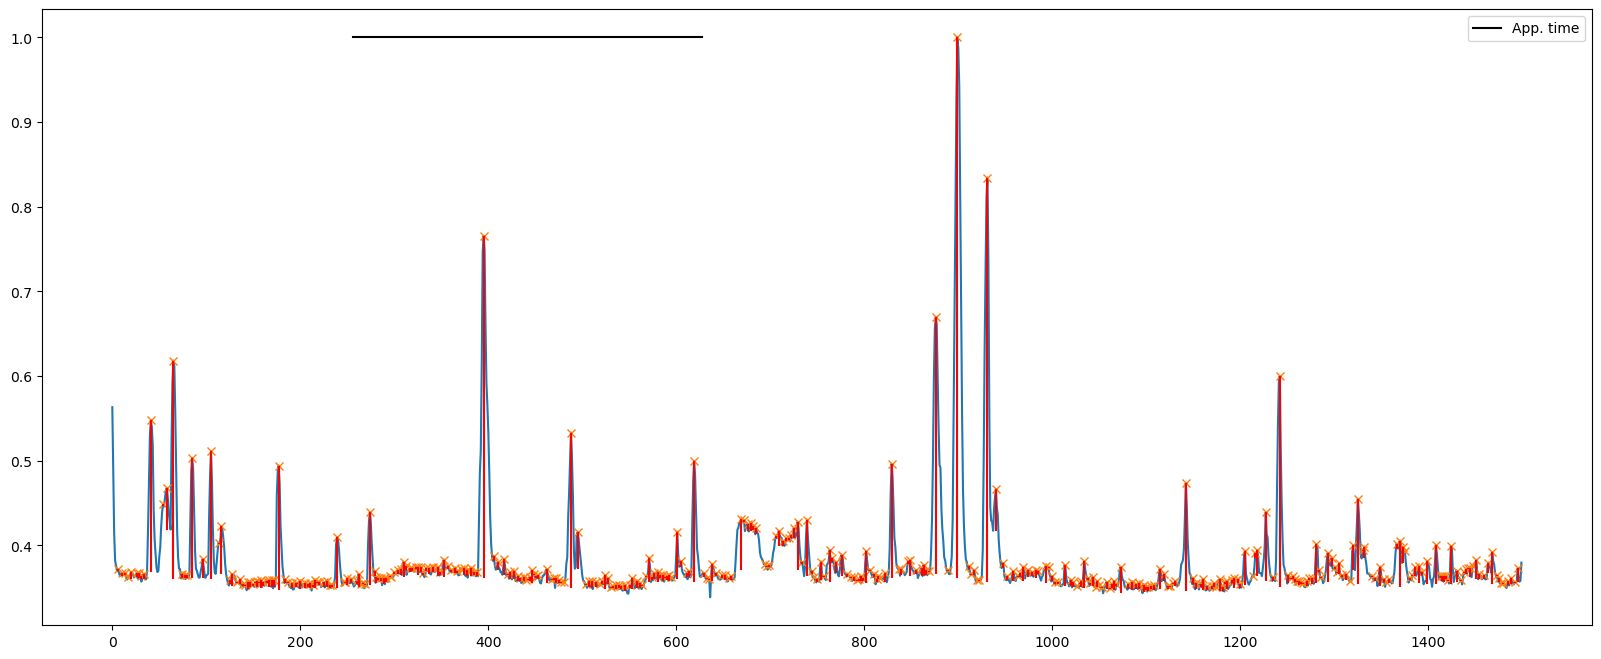

In [44]:
profile_std = np.std(comp_profile)
print(profile_std)

peaks, properties = signal.find_peaks(comp_profile, height=2*profile_std)  # height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None
prom = signal.peak_prominences(comp_profile, peaks, wlen=100)[0]

contour_heights = comp_profile[peaks] - prom
plt.figure(figsize=(20, 8))
plt.plot(comp_profile)
plt.plot(peaks, comp_profile[peaks], "x")
plt.plot(app_time, [np.max(comp_profile)] * len(app_time), label='App. time', color='k')
plt.vlines(x=peaks, ymin=contour_heights, ymax=comp_profile[peaks], color='red')
plt.legend()
plt.show()